In [1]:
import numpy as np

data = np.load("data/data.npz")
images = data["images"]
# The images are stored in a 4D array (n_images, n_eyes, n_rows, n_cols)
print(f"Shape of images: {images.shape}")
# The positions of the second fly are stored in polar coordinates (r, theta)
r = data["r"]
theta = data["theta"]
data.close()

Shape of images: (10000, 2, 16, 31)


In [2]:
################################################################
# TODO: Convert the polar coordinates to cartesian coordinates
coords_lr = r * np.exp(1j * (np.pi / 4 - theta))
coords_lr = np.column_stack([coords_lr.real, coords_lr.imag])
################################################################

# The shape should be (# of samples, 2)
assert coords_lr.shape == (len(images), 2)

In [3]:
import torch
from torch.utils.data import TensorDataset, DataLoader, random_split

dataset = TensorDataset(torch.tensor(images), torch.tensor(coords_lr))
datasets = dict(
    zip(["train", "val", "test"], random_split(dataset, [8000, 1000, 1000]))
)
batch_size = 32
loaders = {
    name: DataLoader(dataset, batch_size=batch_size, shuffle=name == "train")
    for name, dataset in datasets.items()
}

Train the whole model to detect the fly and give the position

In [49]:
from torch import nn
import torch.nn.functional as F

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        # Define your layers here
        self.conv1 = nn.Conv2d(2, 8, 3, groups=2)  # Convolutional layer
        self.bn1 = nn.BatchNorm2d(8)
        self.conv2 = nn.Conv2d(8, 8, 3, groups=2)  # Convolutional layer
        self.bn2 = nn.BatchNorm2d(8)
        self.conv3 = nn.Conv2d(8, 8, 3, groups=2)  # Convolutional layer
        self.pool3 = nn.MaxPool2d(2, 2)  # Max pooling layer
        self.fc1 = nn.LazyLinear(16)  # Lazy linear layer
        self.fc2 = nn.Linear(16, 16)  # Linear layer
        self.fc3 = nn.Linear(16, 2)   # Linear layer for output

    def forward(self, x):
        # Define the forward pass
        x = F.tanh(self.conv1(x))
        x = F.relu(self.bn1(x))
        x = F.tanh(self.conv2(x))
        x = self.bn2(x)  # Apply pooling after the second convolution
        x = F.tanh(self.conv3(x))
        x = self.pool3(x)  # Apply pooling after the third convolution
        x = x.flatten(1)   # Flatten the output to feed into linear layers
        x = F.tanh(self.fc1(x))
        x = F.tanh(self.fc2(x))
        x = self.fc3(x)
        return x


In [50]:
from copy import deepcopy
import torch.optim as optim

model = Model()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
best_val_loss = float("inf")

for epoch in range(500):
    model.train()

    train_loss = 0

    for inputs, labels in loaders["train"]:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(loaders["train"])

    model.eval()

    with torch.no_grad():
        val_loss = 0
        for inputs, labels in loaders["val"]:
            outputs = model(inputs)
            val_loss += criterion(outputs, labels).item()

    val_loss /= len(loaders["val"])

    print(f"Epoch {epoch}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_model_state = deepcopy(model.state_dict())
        best_val_loss = val_loss

/Users/hugo/miniconda3/envs/flygymv1/lib/python3.11/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Epoch 0, Train Loss: 10.8992, Validation Loss: 6.0139
Epoch 1, Train Loss: 4.7583, Validation Loss: 5.7612
Epoch 2, Train Loss: 4.3821, Validation Loss: 4.7506
Epoch 3, Train Loss: 4.2225, Validation Loss: 4.2861
Epoch 4, Train Loss: 4.0843, Validation Loss: 4.1784
Epoch 5, Train Loss: 3.8956, Validation Loss: 4.1522
Epoch 6, Train Loss: 3.6192, Validation Loss: 3.5218
Epoch 7, Train Loss: 3.1415, Validation Loss: 3.1452
Epoch 8, Train Loss: 2.7257, Validation Loss: 2.8316
Epoch 9, Train Loss: 2.5201, Validation Loss: 2.9221
Epoch 10, Train Loss: 2.4331, Validation Loss: 2.5134
Epoch 11, Train Loss: 2.3367, Validation Loss: 2.4188
Epoch 12, Train Loss: 2.2610, Validation Loss: 2.5442
Epoch 13, Train Loss: 2.1944, Validation Loss: 2.3302
Epoch 14, Train Loss: 2.1562, Validation Loss: 2.4360
Epoch 15, Train Loss: 2.0936, Validation Loss: 2.2455
Epoch 16, Train Loss: 2.0873, Validation Loss: 2.2125
Epoch 17, Train Loss: 2.0345, Validation Loss: 2.2799
Epoch 18, Train Loss: 2.0404, Validat

In [51]:
# Save the best model
import os 


if best_model_state is not None:
    model.load_state_dict(best_model_state)
    model_save_directory = 'best_model'  # Define your model directory here
    model_filename = f'best_model_vision.pth'
    save_path_best = os.path.join(model_save_directory, model_filename)

    if not os.path.exists(model_save_directory):
        os.makedirs(model_save_directory)

    torch.save(model.state_dict(), save_path_best)
    print(f"Best model saved to {save_path_best}")
else:
    print("No best model to save.")

Best model saved to best_model/best_model_vision.pth


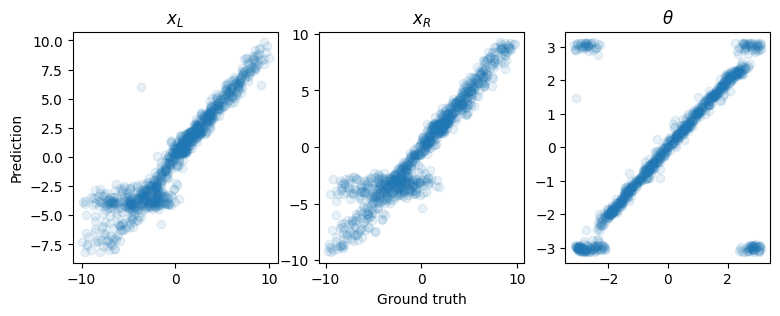

In [52]:
import matplotlib.pyplot as plt



test_indices = datasets["test"].indices
with torch.no_grad():
    coords_lr_pred = model(torch.tensor(images[test_indices])).numpy()

theta_pred = np.angle(coords_lr_pred @ (1, -1j) * np.exp(1j * np.pi / 4))
distances = np.linalg.norm(coords_lr_pred, axis=1)

fig, axs = plt.subplots(1, 3, figsize=(9, 3))
for i in range(2):
    axs[i].scatter(coords_lr[test_indices, i], coords_lr_pred[:, i], alpha=0.1)

axs[2].scatter(theta[test_indices], theta_pred, alpha=0.1)

axs[0].set_ylabel("Prediction")
axs[1].set_xlabel("Ground truth")

for ax, title in zip(axs, ["$x_L$", "$x_R$", "$\\theta$"]):
    ax.set_title(title)

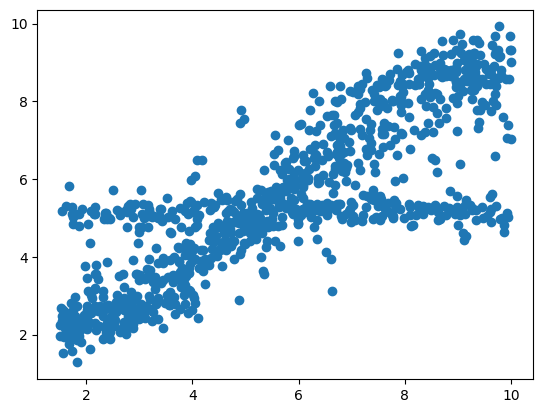

In [53]:
plt.scatter(r[test_indices], distances)


In [54]:
import numpy as np
from flygym.util import get_data_path, load_config


def get_ommatidia_id_matrix():
    data_dir = get_data_path("flygym", "data")
    filename = load_config()["paths"]["ommatidia_id_map"]
    ommatidia_id_map = np.load(data_dir / filename)
    rows = [np.unique(row) for row in ommatidia_id_map]
    max_width = max(len(row) for row in rows)
    rows = np.array([row for row in rows if len(row) == max_width])[:, 1:] - 1
    cols = [np.unique(col) for col in rows.T]
    min_height = min(len(col) for col in cols)
    cols = [col[:min_height] for col in cols]
    rows = np.array(cols).T
    return rows


ommatidia_id_matrix = get_ommatidia_id_matrix()


def crop_hex_to_rect(visual_input):
    return visual_input[..., ommatidia_id_matrix, :].max(-1)

In [55]:
#obs0["vision"].shape
#imgs = crop_hex_to_rect(obs0["vision"])
#imgs.shape
